In [1]:
!mkdir models

In [2]:
!wget https://github.com/richzhang/colorization/blob/caffe/colorization/resources/pts_in_hull.npy?raw=true -O ./pts_in_hull.npy


--2025-06-09 12:23:58--  https://github.com/richzhang/colorization/blob/caffe/colorization/resources/pts_in_hull.npy?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/richzhang/colorization/raw/refs/heads/caffe/colorization/resources/pts_in_hull.npy [following]
--2025-06-09 12:23:58--  https://github.com/richzhang/colorization/raw/refs/heads/caffe/colorization/resources/pts_in_hull.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/richzhang/colorization/refs/heads/caffe/colorization/resources/pts_in_hull.npy [following]
--2025-06-09 12:23:58--  https://raw.githubusercontent.com/richzhang/colorization/refs/heads/caffe/colorization/resources/pts_in_hull.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133,

In [3]:
!wget https://github.com/richzhang/colorization/blob/caffe/models/colorization_deploy_v2.prototxt

--2025-06-09 12:24:02--  https://github.com/richzhang/colorization/blob/caffe/models/colorization_deploy_v2.prototxt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘colorization_deploy_v2.prototxt.1’

colorization_deploy     [ <=>                ] 189.44K  --.-KB/s    in 0.05s   

2025-06-09 12:24:02 (3.68 MB/s) - ‘colorization_deploy_v2.prototxt.1’ saved [193989]



In [4]:
!wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel -O ./models/colorization_release_v2.caffemodel


--2025-06-09 12:24:06--  http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Resolving eecs.berkeley.edu (eecs.berkeley.edu)... 141.193.213.10, 141.193.213.11
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|141.193.213.10|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel [following]
--2025-06-09 12:24:06--  https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-09 12:24:07 ERROR 404: Not Found.



In [5]:
!wget https://github.com/richzhang/colorization/blob/caffe/models/colorization_deploy_v2.prototxt

--2025-06-09 12:24:11--  https://github.com/richzhang/colorization/blob/caffe/models/colorization_deploy_v2.prototxt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘colorization_deploy_v2.prototxt.2’

colorization_deploy     [ <=>                ] 189.44K  --.-KB/s    in 0.05s   

2025-06-09 12:24:11 (3.65 MB/s) - ‘colorization_deploy_v2.prototxt.2’ saved [193991]



In [6]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os.path

In [7]:
!ls /content

colorization_deploy_v2.prototxt      colorization_release_v2.caffemodel
colorization_deploy_v2.prototxt.1    models
colorization_deploy_v2.prototxt.2    pts_in_hull.npy
colorization_deploy_v2.prototxt.txt  sample_data


In [31]:
frame = cv.imread("/content/sun.jpg")

numpy_file = np.load('./pts_in_hull.npy')
#Caffe_net = cv.dnn.readNet("/content/colorization_deploy_v2.prototxt", "/content/colorization_release_v2.caffemodel")
Caffe_net = cv.dnn.readNetFromCaffe("colorization_deploy_v2.prototxt", "colorization_release_v2.caffemodel")

#Caffe_net = cv.dnn.readNet("/content/colorization_deploy_v2.prototxt", "/content/colorization_release_v2.caffemodel")


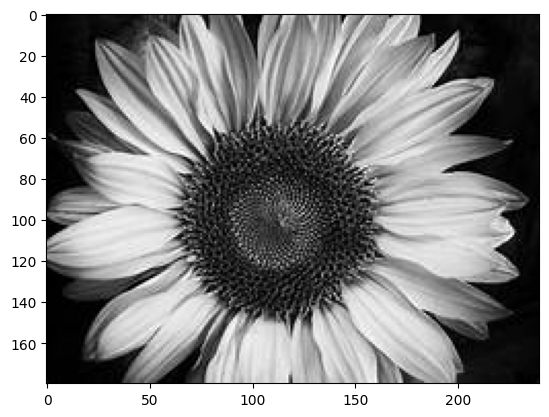

In [32]:
rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)		# this converts the image into RGB
plt.imshow(rgb_img)
plt.show()

In [33]:
numpy_file = numpy_file.transpose().reshape(2, 313, 1, 1) #caffe model layers
Caffe_net.getLayer(Caffe_net.getLayerId('class8_ab')).blobs = [numpy_file.astype(np.float32)]
Caffe_net.getLayer(Caffe_net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

In [34]:
input_width = 224
input_height = 224

rgb_img = (frame[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
lab_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2Lab)
l_channel = lab_img[:,:,0]

l_channel_resize = cv.resize(l_channel, (input_width, input_height))
l_channel_resize -= 50

In [35]:
Caffe_net.setInput(cv.dnn.blobFromImage(l_channel_resize))
ab_channel = Caffe_net.forward()[0,:,:,:].transpose((1,2,0))

(original_height,original_width) = rgb_img.shape[:2]
ab_channel_us = cv.resize(ab_channel, (original_width, original_height))
lab_output = np.concatenate((l_channel[:,:,np.newaxis],ab_channel_us),axis=2)
bgr_output = np.clip(cv.cvtColor(lab_output, cv.COLOR_Lab2BGR), 0, 1)

cv.imwrite("./result.png", (bgr_output*255).astype(np.uint8))

True

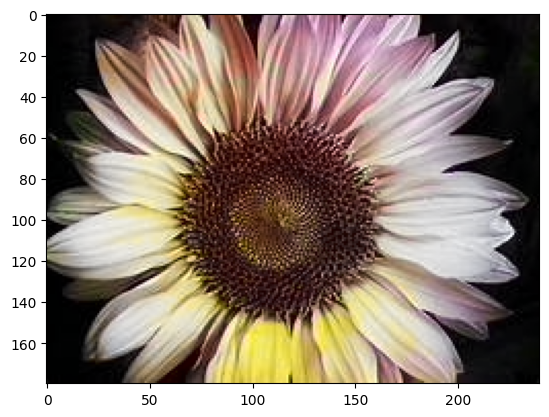

In [36]:
frame1 = cv.imread("result.png")
rgb_img = cv.cvtColor(frame1, cv.COLOR_BGR2RGB)		# this converts it into RGB
plt.imshow(rgb_img)
plt.show()


In [29]:
!pip install gradio

In [44]:
import gradio as gr
import numpy as np
import cv2

# Load your model once globally
net = cv2.dnn.readNetFromCaffe("colorization_deploy_v2.prototxt", "colorization_release_v2.caffemodel")
pts = np.load("pts_in_hull.npy")

# Inject cluster centers as 1x1 convolution kernel
class8_ab = net.getLayerId("class8_ab")
conv8_313_rh = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8_ab).blobs = [pts.astype(np.float32)]
net.getLayer(conv8_313_rh).blobs = [np.full([1, 313], 2.606, dtype="float32")]

def colorize_image(input_image):
    img_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.astype("float32") / 255.0
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    img_l = img_lab[:, :, 0]

    img_resized = cv2.resize(img_l, (224, 224))
    img_resized -= 50
    net.setInput(cv2.dnn.blobFromImage(img_resized))
    ab_dec = net.forward()[0, :, :, :].transpose((1, 2, 0))
    ab_dec_us = cv2.resize(ab_dec, (input_image.shape[1], input_image.shape[0]))

    img_lab_out = np.concatenate((img_l[:, :, np.newaxis], ab_dec_us), axis=2)
    img_bgr_out = cv2.cvtColor(img_lab_out.astype("float32"), cv2.COLOR_Lab2BGR)
    img_bgr_out = np.clip(img_bgr_out, 0, 1)
    return (img_bgr_out * 255).astype("uint8")

# Gradio interface
gr.Interface(
    fn=colorize_image,
    inputs=gr.Image(type="numpy", label="Upload Grayscale Image"),
    outputs=gr.Image(type="numpy", label="Colorized Image"),
    title="Image Colorization with OpenCV + Caffe",
    description="Upload a grayscale image to see it colorized using a deep learning model."
).launch()


error: OpenCV(4.11.0) /io/opencv/modules/dnn/src/net_impl.cpp:279: error: (-204:Requested object was not found) Layer with requested id=-1 not found in function 'getLayerData'
